In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
torch.cuda.is_available()

True

# Domik Dataset

In [3]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [4]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            #print(sample)
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            
            #target = torch.tensor([target], device=device)
            
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data)
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [5]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

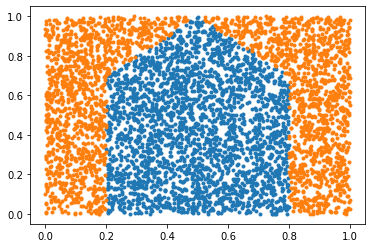

In [125]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

## Net

In [126]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)


In [130]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 13)
        self.fc2 = nn.Linear(13, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.16713924671120464
Epoch        1 Loss: 0.06370014449258586
Epoch        2 Loss: 0.054122869884031005
Epoch        3 Loss: 0.04997803082205825
Epoch        4 Loss: 0.04713770838361624
Epoch        5 Loss: 0.04503467287499531
Epoch        6 Loss: 0.043116207385964216
Epoch        7 Loss: 0.041717053317852054
Epoch        8 Loss: 0.04015376429108709
Epoch        9 Loss: 0.03982788342233897
Epoch       10 Loss: 0.03777442067128566
Epoch       11 Loss: 0.03670419785671772
Epoch       12 Loss: 0.03536902406506003
Epoch       13 Loss: 0.03305950061818691
Epoch       14 Loss: 0.031217324497746935
Epoch       15 Loss: 0.029494081347304756
Epoch       16 Loss: 0.028345390644771436
Epoch       17 Loss: 0.02739614430629499
Epoch       18 Loss: 0.025497381602781005
Epoch       19 Loss: 0.024855560504110117
Epoch       20 Loss: 0.023858279186447867
Epoch       21 Loss: 0.023047739542667638
Epoch       22 Loss: 0.0225021417225344
Epoch       23 Loss: 0.0219958762458934
Epoch   

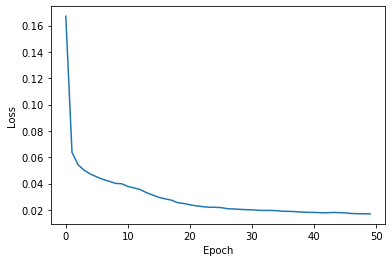

In [131]:
EPOCHS_TO_TRAIN = 50
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

## Test

Accuracy of the network on the 25000 test samples: 98.104


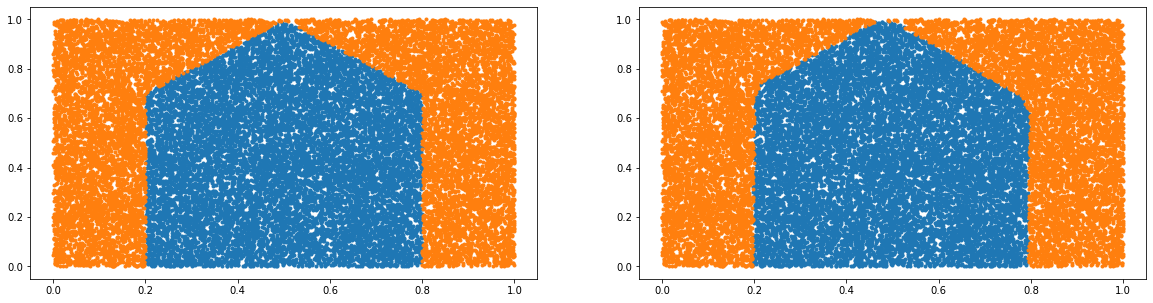

In [132]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik dataset for multi classes

In [140]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

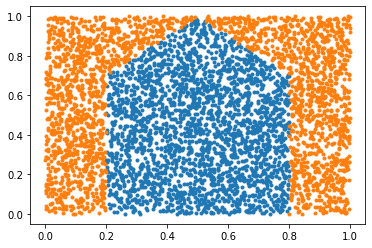

In [141]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

## Net

In [168]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 22)
        self.fc2 = nn.Linear(22, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=22, bias=True)
  (fc2): Linear(in_features=22, out_features=2, bias=True)
)


## Train

Epoch        0 Loss: 0.6933048937087583
Epoch        1 Loss: 0.6931463560803465
Epoch        2 Loss: 0.6931133304589082
Epoch        3 Loss: 0.693080378065012
Epoch        4 Loss: 0.6930773757357903
Epoch        5 Loss: 0.6828969899379499
Epoch        6 Loss: 0.5819576197065275
Epoch        7 Loss: 0.28545919234121925
Epoch        8 Loss: 0.1920792660315593
Epoch        9 Loss: 0.1528591803611934
Epoch       10 Loss: 0.13092500518450997
Epoch       11 Loss: 0.11720553228221543
Epoch       12 Loss: 0.10812780681168453
Epoch       13 Loss: 0.10165994755150533
Epoch       14 Loss: 0.09695553565068236
Epoch       15 Loss: 0.0930018342034718
Epoch       16 Loss: 0.08998927143282281
Epoch       17 Loss: 0.08762555045143315
Epoch       18 Loss: 0.08525502846208102
Epoch       19 Loss: 0.08383201594544372
Epoch       20 Loss: 0.08212434966619957
Epoch       21 Loss: 0.08042855540220081
Epoch       22 Loss: 0.07885434631823636
Epoch       23 Loss: 0.07783911967606479
Epoch       24 Loss: 0.0767

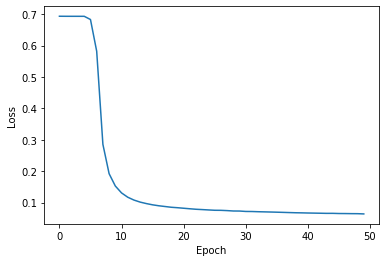

In [169]:
EPOCHS_TO_TRAIN = 50
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.05))

## Test

In [170]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 98.308


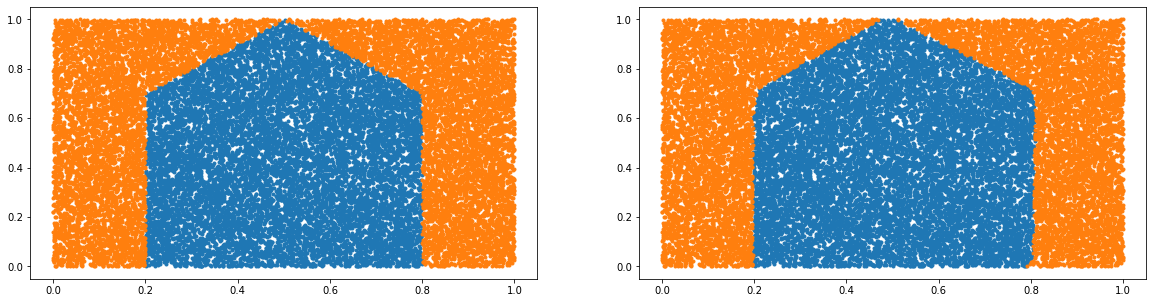

In [171]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik with window dataset

In [176]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

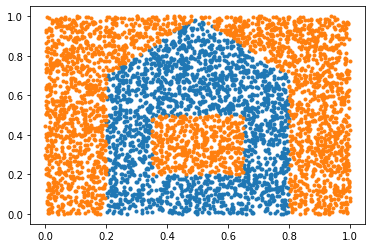

In [251]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)
data = DataLoader(domik, batch_size=5)

# plotting
domik.show()

## Net

In [271]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 42)
        self.fc2 = nn.Linear(42, 42)
        self.fc3 = nn.Linear(42, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=42, bias=True)
  (fc2): Linear(in_features=42, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.18823585510253907
Epoch        1 Loss: 0.12691423034667967
Epoch        2 Loss: 0.10209664154052735
Epoch        3 Loss: 0.0812442855834961
Epoch        4 Loss: 0.06714860534667969
Epoch        5 Loss: 0.06100248336791992
Epoch        6 Loss: 0.057262443542480466
Epoch        7 Loss: 0.05402814102172852
Epoch        8 Loss: 0.051887260437011716
Epoch        9 Loss: 0.05056154251098633
Epoch       10 Loss: 0.0482183837890625
Epoch       11 Loss: 0.0473096923828125
Epoch       12 Loss: 0.04531113815307617
Epoch       13 Loss: 0.04455813980102539
Epoch       14 Loss: 0.042785594940185544
Epoch       15 Loss: 0.04265934753417969
Epoch       16 Loss: 0.040879554748535156
Epoch       17 Loss: 0.041212200164794925
Epoch       18 Loss: 0.03978744506835938
Epoch       19 Loss: 0.039061569213867185
Epoch       20 Loss: 0.03845254516601562
Epoch       21 Loss: 0.03769710540771484
Epoch       22 Loss: 0.03736946487426758
Epoch       23 Loss: 0.03702998352050781
Epoch       2

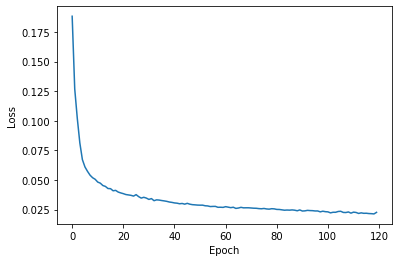

In [272]:
EPOCHS_TO_TRAIN = 120
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.07))

## Test

Accuracy of the network on the 25000 test samples: 98.32


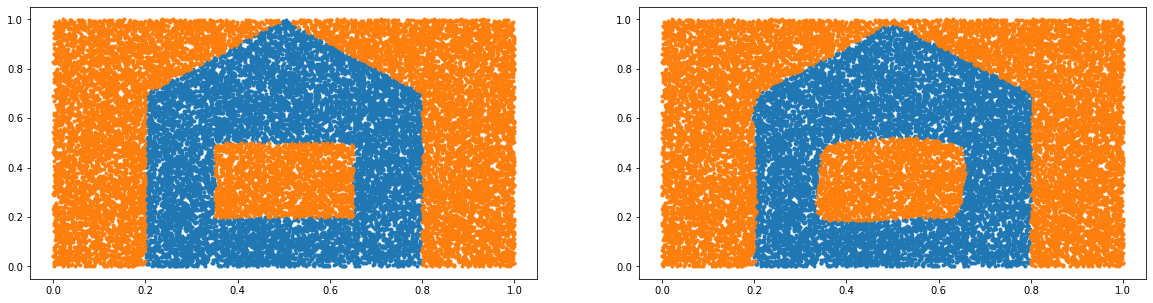

In [273]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Homework

- [ ] Обучить обычный домик (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с окошком (Accuracy >98%). 1 балл
- [ ] Использовать для этого трехслойную сеть. 1 балл
- [ ] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

## Domik with door and 2 windows dataset

In [11]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0.], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0.], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2.], device=device)
                
            targets[i] = int(targets[i].item())
        return points, targets

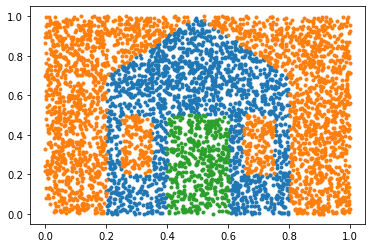

In [12]:
DATASET_SIZE = 5000
domik = DoorDomikDataset(DATASET_SIZE)
domik.show()

## Net

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 13)
        self.fc2 = nn.Linear(13, 13)
        self.fc3 = nn.Linear(13, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=13, bias=True)
  (fc3): Linear(in_features=13, out_features=3, bias=True)
)


## Train

In [14]:
EPOCHS_TO_TRAIN = 50
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.005))

AttributeError: 'int' object has no attribute 'to'

## Test

In [ ]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

In [ ]:
test_dataset = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net, test_dataset=test_dataset)